In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from functions import complex_correlation, colorize, show_colormap_image
import os
import json
from tqdm.auto import tqdm
import time 

# for Jupyter lab
#%matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline

data_folder = './Data/'

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
from scaling_functions import get_inout_modes
from plotting_functions import colorize

import torch
from PyTorchAberrations.cost_functions import norm_mode_to_norm_pix, normalize
from PyTorchAberrations.aberration_models import AberrationModes

# 1. Load data

## 1.1 Load a measured pixel basis TM

(-0.5, 2449.5, 3361.5, -0.5)

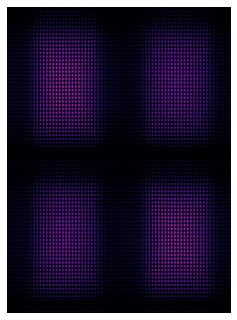

In [3]:
# This TM contains both input and output polarizations seen as four quadrants
TM_pix = np.load(os.path.join(data_folder, 'TM_pix.npy'))
TM_pix/=np.max(np.abs(TM_pix))
TM_pix[np.abs(TM_pix)<1e-3] = 0
fig,ax = plt.subplots(figsize = (4,8))
ax.imshow(np.sqrt(np.abs(TM_pix)),cmap='inferno')
ax.axis('off')

In [4]:
# this indicates the number of input and output polarizations
pola_inout = (2,2)
# number of input and output pixels
N2_out, N2_in = TM_pix.shape
if pola_inout[0]==2:
    N2_in = N2_in//2
if pola_inout[1]==2:
    N2_out = N2_out//2
N_in = int(np.sqrt(N2_in))
N_out = int(np.sqrt(N2_out))

## 1.2 Load modes of the fiber

In [5]:
modes_dict = np.load(os.path.join(data_folder, 'modes_hd.npz'))
print(modes_dict.files)

['betas', 'profiles', 'areaSize', 'npoints', 'nmodes', 'mask_near_degenerate', 'm', 'l']


In [6]:
mask_near_degenerate = modes_dict['mask_near_degenerate']
nmodes = modes_dict['nmodes']

## 1.3 Rescale modes of the fiber

In [22]:
# we use a higher resolution version of the modes and rescale them to 
# get input and output mode with proper scaling
modes_in, modes_out = get_inout_modes(modes_dict['profiles'], TM_pix, pola_inout=pola_inout)
# This is needed because of a flip between th einput and output
modes_out = modes_out.conj()

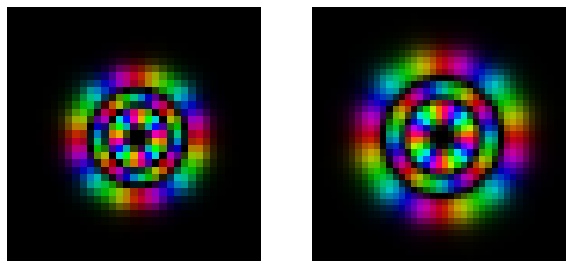

In [23]:
# plot result
fig, axs = plt.subplots(1,2, figsize=(10, 10))
mode_ind = 40
axs[0].imshow(colorize(modes_in[mode_ind].reshape((N_in,N_in))))
axs[1].imshow(colorize(modes_out[mode_ind].reshape((N_out,N_out))))
for ax in axs.ravel():
    ax.axis('off')

# 2. Optimization parameters

In [10]:
# padding coefficient for FFT, float > 0.
# the bigger, the more precise the FFT during the calculations
padding_coeff = 0.05

# list of Zernike polynomials to consider in the Fourier plane (both input and output)
list_zernike_ft = list(range(9))
# list of Zernike polynomials to consider in the direct plane (both input and output)
list_zernike_direct = list(range(14))
# Note: both input and output can be specified separatelly is a list of two lists is provided

# learning rate for the optimizer
learning_rate = 2e-2

# number of epoch to train the model
num_epoch = 200

deformation = 'scaling' # for test, do not modify

# 3. Prepare data

## 3.1 Select a quadrant of the pixel TM measured

In [11]:
# Need to choose single quadrant since correction is scalar
TM_pix_sca = TM_pix[:N_out**2,:N_in**2].astype(complex)

## 3.2 Select device (GPU if available)

In [12]:
device_number = 0 # if you have multiple GPUs
if torch.cuda.is_available():
    print(f'Using GPU: {torch.cuda.get_device_name(device_number)}')
    device = torch.device(f'cuda:{device_number}')
else:
    print(f'No GPU available, running on CPU. Will be slow.')
    device = torch.device('cpu')

No GPU available, running on CPU. Will be slow.


## 3.3 Load modes to device

In [24]:
# Load modes to device and make the pytorch tensors
pt_modes_in = torch.from_numpy(
            modes_in.reshape((-1,N_in,N_in))).to(device)
pt_modes_in.requires_grad = False
pt_modes_out = torch.from_numpy(
            modes_out.reshape((-1,N_out,N_out))).to(device)
pt_modes_out.requires_grad = False

# 4. Prepare optimization

## 4.1 Initialize the model

In [25]:
model = AberrationModes(
    inpoints = N_in, 
    onpoints = N_out, 
    padding_coeff = padding_coeff, # if the gpu memory gets full, reduce it to just above 0
    list_zernike_ft = list_zernike_ft,
    list_zernike_direct = list_zernike_direct,
    deformation = deformation
).to(device)

## 4.2 Define the cost function
We want to maximize the energy of the TM projected onto the mode basis.

The cost function (to minimize) is the inverse of the ratio of between 
the norm squared of the TM in the mode basis by the norm squared of the TM in the pixel basis.

In [26]:
loss_fn = lambda A: norm_mode_to_norm_pix(
                torch.from_numpy(TM_pix_sca).to(device),
                A[0],
                A[1], 
                N_out,
                N_in)

## 4.3 Initialize the optimizer

We use the Adam optimizer

In [27]:
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate
)

# 5. Optimization 

## 5.1 Calculate energy criteria before optimization

In [28]:
evol_energy_ratio = []
evol_diag_ratio = []
evol_diag_ratio_indx = [0]


TM_modes_before = modes_out @ TM_pix_sca @ modes_in.T.conj()
# ratio of energy after projection to the energy of the full pixel matrix
energy_ratio = (np.linalg.norm(TM_modes_before)/np.linalg.norm(TM_pix_sca))**2
# ratio of the energy on the block diagonal (degenerate groups)
# of the mode basis TM compared to the total energy of the mode basis TM
energy_on_diagonal =np.linalg.norm(TM_modes_before*mask_near_degenerate)**2
diag_ratio = energy_on_diagonal/np.linalg.norm(TM_modes_before)**2

evol_energy_ratio.append(energy_ratio)
evol_diag_ratio.append(diag_ratio)

print(f"Initial ratios: conversion = {100*energy_ratio:.3f}%, \t diagonal = {100*diag_ratio:.3f}%")

Initial ratios: conversion = 60.184%, 	 diagonal = 16.374%


## 5.2 Optimization loop

In [29]:
 # get the first guess using the initial parameters
y_pred = model(pt_modes_in, pt_modes_out)
loss = loss_fn(y_pred)
best = loss.item()

t0 = time.time()        
t = tqdm(range(num_epoch),
            bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
        
for epoch in t:

    # infer the input and output projection matrices from the model
    y_pred = model(pt_modes_in,pt_modes_out)
    # normalize the input and output projection matrices
    y_pred = [normalize(y_pred[0]), normalize(y_pred[1])]
    loss = loss_fn(y_pred)        
    optimizer.zero_grad() 

    # backward propagation done by autograd
    loss.backward()

    # update the parameters
    optimizer.step()

    if loss.item() < best :
        best  = loss.item()
        best_state = (model.abberation_output.state_dict(),
                      model.abberation_input.state_dict())

    # show some stats
    if epoch % 10 == 0 or epoch == num_epoch-1:
        
        modes_out_corr = y_pred[0].detach().cpu().numpy().reshape(nmodes,-1)
        modes_in_corr = y_pred[1].detach().cpu().numpy().reshape(nmodes,-1)
        # Project onto the modes
        TM_modes_temp = modes_out_corr @ TM_pix_sca @ modes_in_corr.T.conj()                
        # ratio of energy after projection to the energy of the full pixel matrix
        energy_ratio = (np.linalg.norm(TM_modes_temp)/np.linalg.norm(TM_pix_sca))**2
        # ratio of energy on block diagonal to total
        energy_on_diagonal =np.linalg.norm(TM_modes_temp*mask_near_degenerate)**2
        diag_ratio = energy_on_diagonal/np.linalg.norm(TM_modes_temp)**2    
        #
        evol_energy_ratio.append(energy_ratio)        
        evol_diag_ratio.append(diag_ratio)
        evol_diag_ratio_indx.append(epoch)
        
        message = f"conversion = {100*energy_ratio:.3f}% | diag = {100*diag_ratio:.3f}%"               
        t.set_description(message)
        t.update(1)

t1 = time.time()
print(f'Computation took {t1-t0:.1f} seconds.') 

modes_out_corr = y_pred[0].detach().cpu().numpy().reshape(nmodes,-1)
modes_in_corr = y_pred[1].detach().cpu().numpy().reshape(nmodes,-1)
TM_modes_corr = modes_out_corr @ TM_pix_sca @ modes_in_corr.T.conj()


c:\Users\Rodrigo.SAOPAULO\anaconda3\lib\site-packages\torch\nn\functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]

conversion = 91.689% | diag = 86.642%: 100%|██████████| 200/200 [00:44<00:00,  4.47it/s]

Computation took 44.8 seconds.


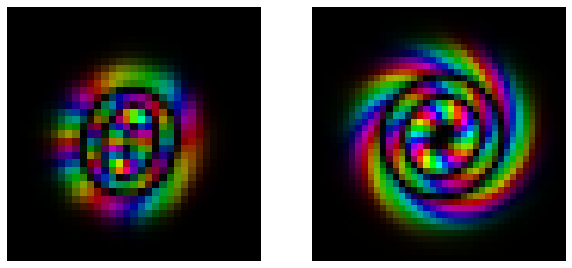

In [30]:
# plot result
fig, axs = plt.subplots(1,2, figsize=(10, 10))
mode_ind = 40
axs[0].imshow(colorize(modes_in_corr[mode_ind].reshape((N_in,N_in))))
axs[1].imshow(colorize(modes_out_corr[mode_ind].reshape((N_out,N_out))))
for ax in axs.ravel():
    ax.axis('off')

# 6. Results

## 6.1 Plot evolution

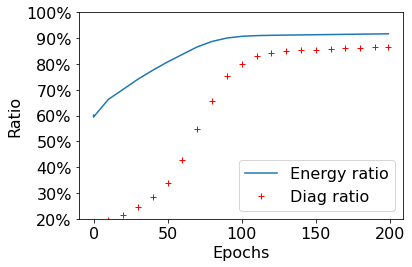

In [31]:
plt.figure()
plt.plot(evol_diag_ratio_indx,evol_energy_ratio, label = 'Energy ratio')
plt.plot(evol_diag_ratio_indx, evol_diag_ratio, 'r+', label = 'Diag ratio' )
plt.legend()
yticks = list(np.arange(0.2,1.1,0.1))
plt.yticks(yticks,[f'{y*100:g}%' for y in yticks])
plt.ylim([0.2,1.])
plt.xlabel('Epochs')
plt.ylabel('Ratio')
plt.tight_layout()
# plt.savefig('evolution_optimization.svg')

## 6.2 Mode TM before and after

Text(0.5, 0.98, 'Amplitude of the mode basis TM')

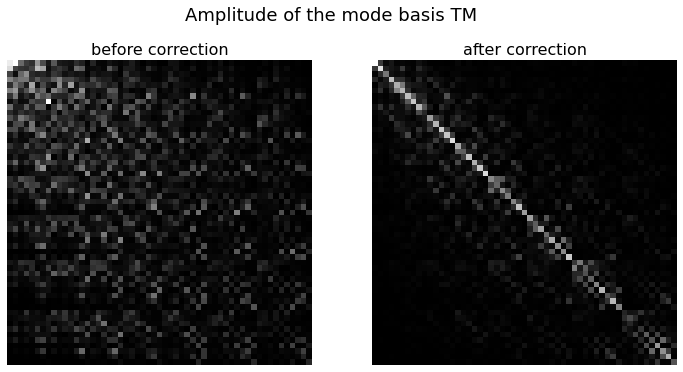

In [32]:
TM_modes_after = TM_modes_temp

fig ,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(np.abs(TM_modes_before), cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('before correction')
ax[1].imshow(np.abs(TM_modes_after), cmap = 'gray')
ax[1].axis('off')
ax[1].set_title('after correction')
fig.suptitle('Amplitude of the mode basis TM')

## 6.3 Show Zernike coefficients

In [20]:
best_Zernike_coeff = [getZernikeCoefs(model.abberation_output.state_dict()),
                   getZernikeCoefs(model.abberation_input.state_dict())]

/home/spopoff/dev/PyTorchAberrations/functions.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(zernike_names, rotation=40, ha='right')


(<Figure size 864x504 with 2 Axes>,
 <AxesSubplot:xlabel='Name of correction function', ylabel='Amplitude of correction'>,
 [3, 4, 13, 21])

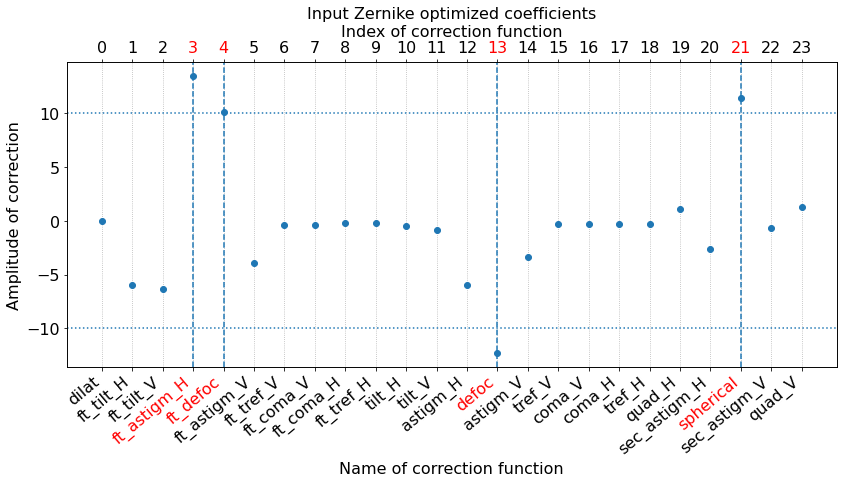

In [21]:
showZernikeCoefs(best_Zernike_coeff[0], title = 'Input Zernike optimized coefficients')
#plt.savefig('input_zernike.svg')

(<Figure size 864x504 with 2 Axes>,
 <AxesSubplot:xlabel='Name of correction function', ylabel='Amplitude of correction'>,
 [4, 12])

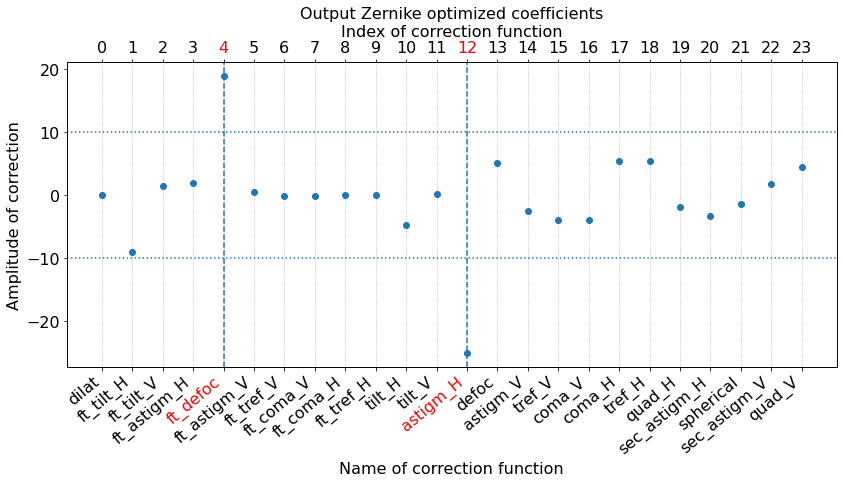

In [22]:
showZernikeCoefs(best_Zernike_coeff[1], title = 'Output Zernike optimized coefficients')
#plt.savefig('output_zernike.svg')